In [1]:
# load selected feature
import numpy as np


# for p < 0.05
#pTh=0.05
#X=np.loadtxt("./old_cor&old_incor/p0.05/WT_3s_X_p0.05.txt")
#X_scaled=np.loadtxt("./old_cor&old_incor/p0.05/WT_3s_X_scaled_p0.05.txt")
#Y=np.loadtxt("./old_cor&old_incor/p0.05/WT_3s_Y_p0.05.txt")
#listSelectedFeature = np.loadtxt("./old_cor&old_incor/p0.05/listSelectedFeature_p{}.txt".format(pTh))

# ## for p < 0.1
pTh=0.1
X=np.loadtxt("./old_stim/p0.1/WT_3s_X_p0.1.txt")
X_scaled=np.loadtxt("./old_stim/p0.1/WT_3s_X_scaled_p0.1.txt")
Y=np.loadtxt("./old_stim/p0.1/WT_3s_Y_p0.1.txt")
listSelectedFeature = np.loadtxt("./old_stim/p0.1/listSelectedFeature_p{}.txt".format(pTh))




# # for p < 0.15
# pTh=0.15
# X=np.loadtxt("./old_stim/p0.15/WT_3s_X_p0.15.txt")
# X_scaled=np.loadtxt("./old_stim/p0.15/WT_3s_X_scaled_p0.15.txt")
# Y=np.loadtxt("./old_stim/p0.15/WT_3s_Y_p0.15.txt")
# listSelectedFeature = np.loadtxt("./old_stim/p0.15/listSelectedFeature_p{}.txt".format(pTh))



print(X.shape)
print(X_scaled.shape)
print(Y.shape)

#baseAcc = np.mean(Y==1) # this is baseline
baseAcc = 7/9
print(baseAcc)

(62, 210)
(62, 210)
(62,)
0.7777777777777778


## Scaling matters!

In [2]:
## Let's start from linear SVM 
from sklearn.svm import LinearSVC
# http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
from sklearn import svm

##  without scaling!
clf = svm.LinearSVC(C=10, loss="hinge",  random_state=42)  # class_weight='balanced',

clf.fit(X,Y)

# training classfication error
Yhat = clf.predict(X)
print(np.mean(Y==Yhat))
print(np.std(Y==Yhat))



## with scaling
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=10, loss="hinge", random_state=42)), # class_weight='balanced', 
    ])

clf.fit(X,Y)

# training classfication error
Yhat = clf.predict(X)
print(np.mean(Y==Yhat))
print(np.std(Y==Yhat))

## SCALING IS IMPORTANT!

1.0
0.0
1.0
0.0


## Let's do cross-validation

In [3]:
## cross validation
from sklearn.model_selection import cross_val_score
from sklearn import svm

# linear classifier
clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=10, loss="hinge",  random_state=42)), # class_weight='balanced',
    ])

# run cross validation
scores = cross_val_score(clf, X, Y, cv=5)

print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.92307692 1.         0.84615385 0.91666667 0.90909091]
Accuracy: 0.92 (+/- 0.10)


max accuracy = 0.9189976689976689 when C=0.1


Text(0,0.5,'accuracy')

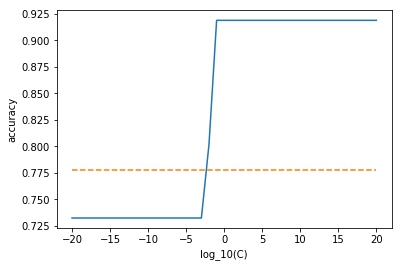

In [4]:
# repeat for a wide range of C
Cs = 10**np.linspace(-20,20,41)
Cs

k = 5
scores = list()
for C in Cs:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=C, loss="hinge",  random_state=42)), # class_weight='balanced',
    ])

    scores.append(cross_val_score(clf, X, Y, cv=k))
    
#scores

mean_scores = np.mean(scores,axis=1)
#print(mean_scores)

maxIdx=np.argmax(mean_scores)
print("max accuracy = {} when C={}".format(mean_scores[maxIdx], Cs[maxIdx]))




import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.log10(Cs),mean_scores)
plt.plot(np.log10(Cs), baseAcc*np.ones_like(Cs), '--')
plt.xlabel('log_10(C)')
plt.ylabel('accuracy')
    

    


## Adding `balancing` 


max accuracy = 0.9189976689976689 when C=0.1


Text(0,0.5,'accuracy')

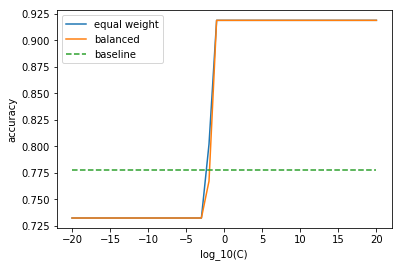

In [5]:
# repeat for a wide range of C
Cs = 10**np.linspace(-20,20,41)
Cs

k = 5
scores = list()
for C in Cs:
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=C, loss="hinge",  class_weight='balanced', random_state=42)),  # balanced!
    ])

    scores.append(cross_val_score(clf, X, Y, cv=k))
    
#scores

mean_scores_balanced = np.mean(scores,axis=1)
#print(mean_scores_balanced)

maxIdx=np.argmax(mean_scores_balanced)
print("max accuracy = {} when C={}".format(mean_scores_balanced[maxIdx], Cs[maxIdx]))




import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.log10(Cs),mean_scores)
plt.plot(np.log10(Cs),mean_scores_balanced)
plt.plot(np.log10(Cs), baseAcc*np.ones_like(Cs), '--')
plt.legend(('equal weight','balanced', 'baseline'))
plt.xlabel('log_10(C)')
plt.ylabel('accuracy')
    

In [6]:
# let's repeat & check confusion matrix!

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=10, loss="hinge", random_state=42)),  # balanced!
    #("linear_svc", LinearSVC(C=10, loss="hinge",  class_weight='balanced', random_state=42)),  # balanced!
])
    

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

split = StratifiedShuffleSplit(n_splits=5, test_size=1/5, random_state=42)

k = 0

acc_train = list()
acc_test = list()
for train_index, test_index in split.split(X,Y):
#    print(train_index)
#    print(test_index)
    if k==0:   # print info
        print("In the training set of size{},".format(Y[train_index].shape))
        print("cor: {}, incor: {}".format(sum(Y[train_index]==1),sum(Y[train_index]==-1)))
        print("In the training set of size{},".format(Y[test_index].shape))    
        print("cor: {}, incor: {}".format(sum(Y[test_index]==1),sum(Y[test_index]==-1)))
        baseAcc = sum(Y[test_index]==1) / (sum(Y[test_index]==1)+sum(Y[test_index]==-1)) 
        print("base accuracy = {}".format(baseAcc))

    X_train = X[train_index,:]
    Y_train = Y[train_index]
    X_test = X[test_index,:]    
    Y_test = Y[test_index]
    
    clf.fit(X_train,Y_train)

    # training error
    Yhat_train = clf.predict(X_train)
    acc_train.append(np.mean(Yhat_train==Y_train))

    # test error
    Yhat_test = clf.predict(X_test)
    acc_test.append(np.mean(Yhat_test==Y_test))
 
    cm = confusion_matrix(Y_test, Yhat_test, labels=(1,-1))
    print(cm)

#     # let's manually check
#     print(sum((Y_test == 1) & (Yhat_test == 1)))    # 1s are (correctly) predicted as 1s
#     print(sum((Y_test == 1) & (Yhat_test == -1)))   # 1s are predicted as -1
#     print(sum((Y_test == -1) & (Yhat_test == 1)))   # -1s are predicted as 1
#     print(sum((Y_test == -1) & (Yhat_test == -1)))  # -1s are (correctly) predicted as -1

    
    k = k + 1
print("training accuracy")    
print(acc_train)
print("test accuracy")    
print(acc_test)
print(np.mean(acc_test))

In the training set of size(49,),
cor: 42, incor: 7
In the training set of size(13,),
cor: 11, incor: 2
base accuracy = 0.8461538461538461
[[8 3]
 [0 2]]
[[8 3]
 [0 2]]
[[9 2]
 [0 2]]
[[9 2]
 [0 2]]
[[10  1]
 [ 0  2]]
training accuracy
[1.0, 1.0, 1.0, 1.0, 1.0]
test accuracy
[0.7692307692307693, 0.7692307692307693, 0.8461538461538461, 0.8461538461538461, 0.9230769230769231]
0.8307692307692308


array([], shape=(0, 2), dtype=float64)

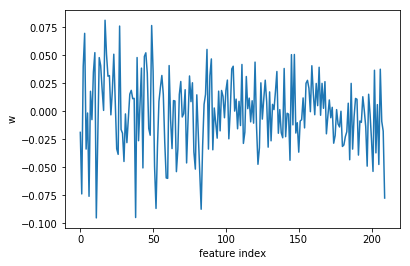

In [7]:
# re-train using all the data (CAN I DO THIS?)

clf.fit(X,Y)

# get coefficient of SVM
w = clf.named_steps['linear_svc'].coef_
#print(w)
w = w.ravel()
#w.shape
plt.plot(w)
plt.ylabel('w')
plt.xlabel('feature index')


w.shape
#listSelectedFeature.shape
listSelectedFeature[w>0.1,:]

listSelectedFeature[w<-0.1,:]


In [8]:
#X.shape
#Y.shape
#w.shape
#listSelectedFeature.shape

## So, conclusions are
* linear SVM does *NOT* work for p<0.05
* linear SVM does workf for p<0.1

## Nonlinear SVMs

1.0


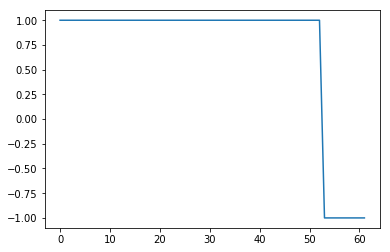

In [9]:
from sklearn.pipeline import Pipeline

rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", svm.SVC(kernel="rbf", gamma=2, C=10,random_state=42))   # class_weight='balanced',
    ])
    
rbf_kernel_svm_clf.fit(X, Y)

Yhat=rbf_kernel_svm_clf.predict(X)
print(np.mean(Y==Yhat))
plt.plot(Yhat)

## Cross validation with nonlinear SVM

In [10]:
# repeat for a wide range of gamma and C

Gs=2**np.linspace(-7,3,11)
Gs
Cs = 10**np.linspace(-20,20,41)
Cs


# unbalanced 
k = 5
gs = list()
cs = list()
scores = list()
for G in Gs:
    print("gamma={}".format(G))
    for C in Cs:
        rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", svm.SVC(kernel="rbf", gamma=G, C=C,random_state=42))   # class_weight='balanced',
        ])
        gs.append(G)
        cs.append(C)
        scores.append(cross_val_score(rbf_kernel_svm_clf, X, Y, cv=k))


mean_scores = np.mean(scores,axis=1)
#print(mean_scores)    


maxIdx=np.argmax(mean_scores)
print("max accuracy = {} when gamma={} and C={}".format(mean_scores[maxIdx], gs[maxIdx], cs[maxIdx]))




# save results to files
np.savetxt("gamma.txt", gs)
np.savetxt("C.txt", Cs)
np.savetxt("scores.txt", scores)
np.savetxt("mean_scores.txt", mean_scores)


gamma=0.0078125
gamma=0.015625
gamma=0.03125
gamma=0.0625
gamma=0.125
gamma=0.25
gamma=0.5
gamma=1.0
gamma=2.0
gamma=4.0
gamma=8.0
max accuracy = 0.8561771561771561 when gamma=0.0078125 and C=1e-20


Text(0,0.5,'accuracy')

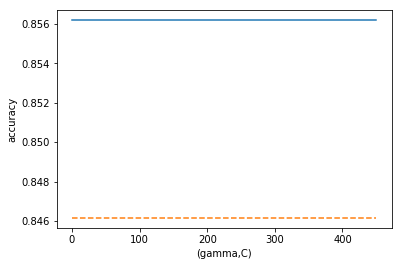

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mean_scores)
#plt.plot(np.log10(Cs), mean_scores)
plt.plot(baseAcc*np.ones_like(mean_scores), '--')
plt.xlabel('(gamma,C)')
plt.ylabel('accuracy')

In [12]:
0.8905555555555555*9

8.015

## add balance

In [13]:
## add balance

Gs=2**np.linspace(-7,3,11)
Gs
Cs = 10**np.linspace(-20,20,41)
Cs


# unbalanced 
k = 5
gs = list()
cs = list()
scores_balanced = list()
for G in Gs:
    print("gamma={}".format(G))
    for C in Cs:
        rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", svm.SVC(kernel="rbf", gamma=G, C=C, class_weight='balanced', random_state=42))   # ,
        ])
        gs.append(G)
        cs.append(C)
        scores_balanced.append(cross_val_score(rbf_kernel_svm_clf, X, Y, cv=k))


mean_scores_balanced = np.mean(scores_balanced,axis=1)
#print(mean_scores)    


maxIdx=np.argmax(mean_scores_balanced)
print("max accuracy = {} when gamma={} and C={}".format(mean_scores_balanced[maxIdx], gs[maxIdx], cs[maxIdx]))




# save results to files
np.savetxt("gamma_balanced.txt", gs)
np.savetxt("C_balanced.txt", Cs)
np.savetxt("scores_balanced.txt", scores_balanced)
np.savetxt("mean_scores_balanced.txt", mean_scores_balanced)


gamma=0.0078125
gamma=0.015625
gamma=0.03125
gamma=0.0625
gamma=0.125
gamma=0.25
gamma=0.5
gamma=1.0
gamma=2.0
gamma=4.0
gamma=8.0
max accuracy = 0.9331002331002332 when gamma=0.0625 and C=1e-19


Text(0,0.5,'accuracy')

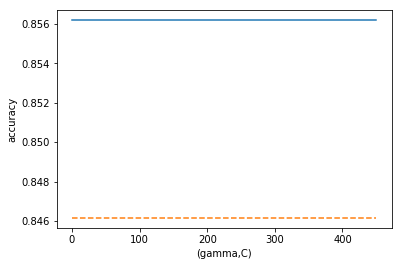

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(mean_scores)
#plt.plot(np.log10(Cs), mean_scores)
plt.plot(baseAcc*np.ones_like(mean_scores), '--')
plt.xlabel('(gamma,C)')
plt.ylabel('accuracy')

In [15]:
# refit using the best param
rbf_kernel_svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", svm.SVC(kernel="rbf", gamma=0.03125, C=1, class_weight='balanced', random_state=42))   # ,
])

rbf_kernel_svm_clf.fit(X,Y)

# training error = 0
Yhat = rbf_kernel_svm_clf.predict(X)
np.mean(Yhat==Y)

1.0

In [16]:
# let's repeat & check confusion matrix!

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix

split = StratifiedShuffleSplit(n_splits=5, test_size=1/5, random_state=42)

k = 0

acc_train = list()
acc_test = list()
for train_index, test_index in split.split(X,Y):
#    print(train_index)
#    print(test_index)
    if k==0:   # print info
        print("In the training set of size{},".format(Y[train_index].shape))
        print("cor: {}, incor: {}".format(sum(Y[train_index]==1),sum(Y[train_index]==-1)))
        print("In the training set of size{},".format(Y[test_index].shape))    
        print("cor: {}, incor: {}".format(sum(Y[test_index]==1),sum(Y[test_index]==-1)))
        baseAcc = sum(Y[test_index]==1) / (sum(Y[test_index]==1)+sum(Y[test_index]==-1)) 
        print("base accuracy = {}".format(baseAcc))

    X_train = X[train_index,:]
    Y_train = Y[train_index]
    X_test = X[test_index,:]    
    Y_test = Y[test_index]
    
    rbf_kernel_svm_clf.fit(X_train,Y_train)

    # training error
    Yhat_train = rbf_kernel_svm_clf.predict(X_train)
    acc_train.append(np.mean(Yhat_train==Y_train))

    # test error
    Yhat_test = rbf_kernel_svm_clf.predict(X_test)
    acc_test.append(np.mean(Yhat_test==Y_test))
 
    cm = confusion_matrix(Y_test, Yhat_test, labels=(1,-1))
    print(cm)

#     # let's manually check
#     print(sum((Y_test == 1) & (Yhat_test == 1)))    # 1s are (correctly) predicted as 1s
#     print(sum((Y_test == 1) & (Yhat_test == -1)))   # 1s are predicted as -1
#     print(sum((Y_test == -1) & (Yhat_test == 1)))   # -1s are predicted as 1
#     print(sum((Y_test == -1) & (Yhat_test == -1)))  # -1s are (correctly) predicted as -1

    
    k = k + 1
print("training accuracy")    
print(acc_train)
print("test accuracy")    
print(acc_test)
print(np.mean(acc_test))
print(np.std(acc_test))

In the training set of size(49,),
cor: 42, incor: 7
In the training set of size(13,),
cor: 11, incor: 2
base accuracy = 0.8461538461538461
[[11  0]
 [ 2  0]]
[[11  0]
 [ 2  0]]
[[11  0]
 [ 2  0]]
[[11  0]
 [ 2  0]]
[[11  0]
 [ 2  0]]
training accuracy
[1.0, 1.0, 1.0, 1.0, 1.0]
test accuracy
[0.8461538461538461, 0.8461538461538461, 0.8461538461538461, 0.8461538461538461, 0.8461538461538461]
0.8461538461538461
0.0


In [17]:
Yhat_test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [18]:
8/9

0.8888888888888888